# Conditional Neural Cellular Automata (c-NCA) for MNIST
**Author:** Ali Sakour  
**Affiliation:** Lattakia University, Lattakia, Syria  
**Paper:** *Conditional Morphogenesis: Emergent Generation of Structural Digits via Neural Cellular Automata*

---
### Description
This notebook implements the official code for the c-NCA paper. It demonstrates how a single neural rule set can learn to grow distinct MNIST digits based on a conditional vector.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Running on: {device}")

 Running on: cuda


In [5]:
class Config:
    device = device
    image_size = 28       
    CHANNEL_N = 16       
    BATCH_SIZE = 64
    N_EPOCHS = 25      
    N_STEPS = 64          
    LR = 1e-3             
    MODEL_PATH = "c_nca_mnist.pth"

opt = Config()

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=opt.BATCH_SIZE, shuffle=True, num_workers=0)

print(f"✅ Data Loaded: {len(dataset)} training images.")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 144kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]

✅ Data Loaded: 60000 training images.


In [6]:
class ConditionalNCA(nn.Module):
    """
    Conditional Neural Cellular Automata model.
    It learns local update rules to grow digit structures conditioned on a class vector.
    """
    def __init__(self, channel_n=16, num_classes=10):
        super().__init__()
        self.channel_n = channel_n
        
        self.perceive = nn.Conv2d(channel_n, channel_n * 3, 3, padding=1, groups=channel_n, bias=False)
        
        self.update_net = nn.Sequential(
            nn.Conv2d(channel_n * 3 + num_classes, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, channel_n, 1)
        )
        
        with torch.no_grad():
            self.update_net[-1].weight.zero_()
            self.update_net[-1].bias.zero_()

    def forward(self, x, class_vec, steps):
        for _ in range(steps):
            perception = self.perceive(x)
            B, _, H, W = x.shape
            class_map = class_vec.view(B, -1, 1, 1).expand(B, -1, H, W)
            perception_cond = torch.cat([perception, class_map], dim=1)
            dx = self.update_net(perception_cond)
            update_mask = (torch.rand(B, 1, H, W, device=x.device) > 0.5).float()
            x = x + dx * update_mask
            alive = F.max_pool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1
            x = x * alive.float()
            
        return x

model = ConditionalNCA(opt.CHANNEL_N, 10).to(opt.device)
print(model)

ConditionalNCA(
  (perceive): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
  (update_net): Sequential(
    (0): Conv2d(58, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
  )
)


Starting Training Process...


Epoch 5/25: 100%|██████████| 938/938 [02:57<00:00,  5.30it/s, Loss=0.0688]


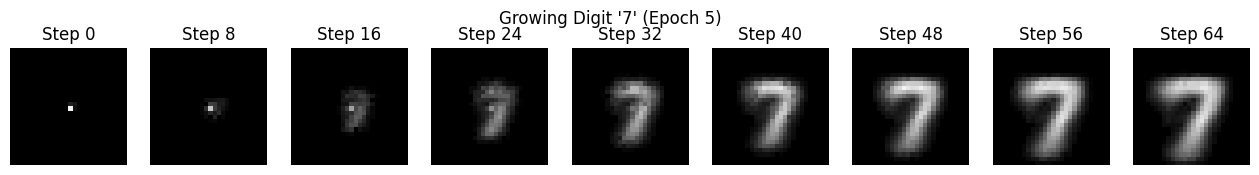

Epoch 10/25: 100%|██████████| 938/938 [02:57<00:00,  5.30it/s, Loss=0.0548]


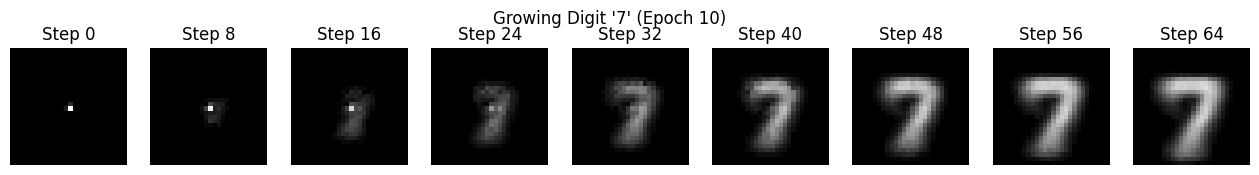

Epoch 15/25: 100%|██████████| 938/938 [02:58<00:00,  5.24it/s, Loss=0.0545]


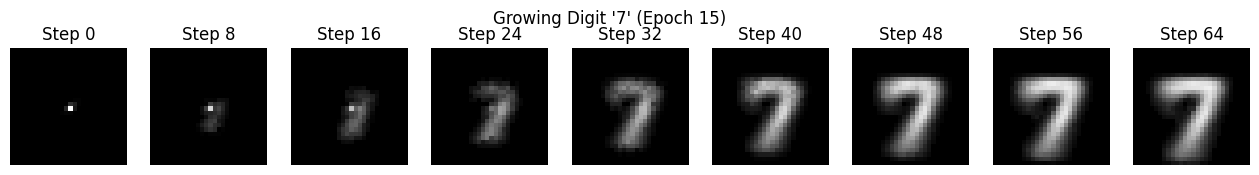

Epoch 20/25: 100%|██████████| 938/938 [02:58<00:00,  5.25it/s, Loss=0.0621]


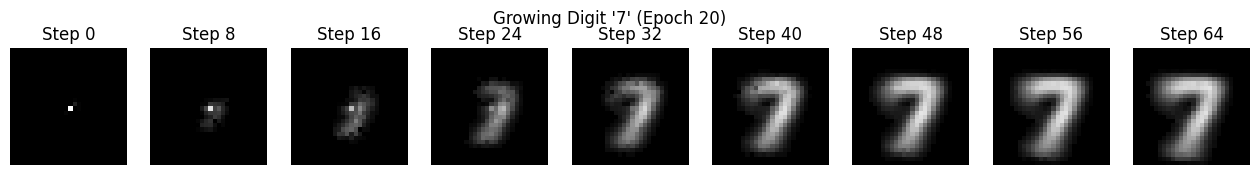

Epoch 25/25: 100%|██████████| 938/938 [02:58<00:00,  5.25it/s, Loss=0.0637]


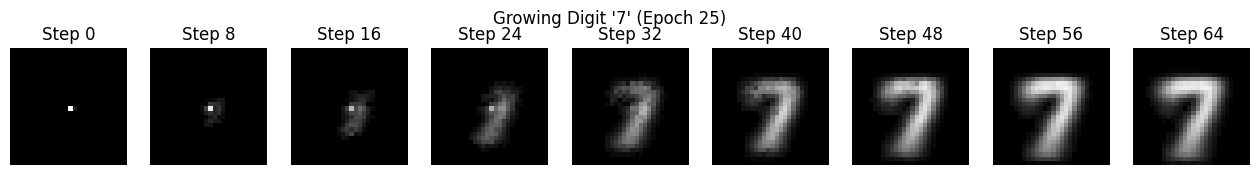

 Training Complete & Model Saved!


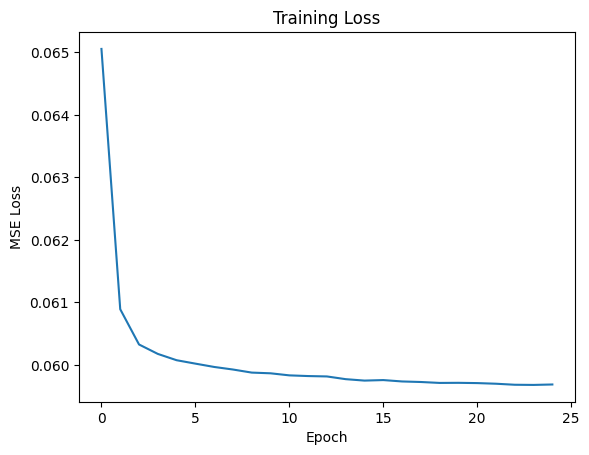

In [6]:

optimizer = optim.Adam(model.parameters(), lr=opt.LR)
loss_history = []

print("Starting Training Process...")

for epoch in range(opt.N_EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{opt.N_EPOCHS}")
    
    for images, labels in pbar:
        images = images.to(opt.device)
        labels = labels.to(opt.device)
        B = images.size(0)
        
        rgb_images = images.repeat(1, 3, 1, 1) 
        alpha_channel = (images > 0.1).float()
        target_rgba = torch.cat([rgb_images, alpha_channel], dim=1)
        
        seed = torch.zeros(B, opt.CHANNEL_N, opt.image_size, opt.image_size).to(opt.device)
        seed[:, 3:, opt.image_size//2, opt.image_size//2] = 1.0 
        
        class_vec = F.one_hot(labels, num_classes=10).float()
        
        output = model(seed, class_vec, opt.N_STEPS)
        
        loss = F.mse_loss(output[:, :4], target_rgba)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'Loss': loss.item()})
        
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            digit_to_grow = 7
            test_cls = torch.tensor([digit_to_grow]).to(opt.device)
            class_vec_vis = F.one_hot(test_cls, 10).float()
            
            seed_vis = torch.zeros(1, opt.CHANNEL_N, opt.image_size, opt.image_size).to(opt.device)
            seed_vis[:, 3:, opt.image_size//2, opt.image_size//2] = 1.0
            
            states = []
            x = seed_vis
            
            for step in range(opt.N_STEPS):
                x = model(x, class_vec_vis, 1) 
                
                if step % (opt.N_STEPS // 8) == 0 or step == opt.N_STEPS - 1:
                    states.append(x[0, :4].cpu())
            
            fig, axes = plt.subplots(1, len(states), figsize=(16, 2))
            for k, state in enumerate(states):
                img = state[3].clamp(0, 1).numpy()
                axes[k].imshow(img, cmap='gray', vmin=0, vmax=1)
                axes[k].set_title(f"Step {k * (opt.N_STEPS // 8)}")
                axes[k].axis('off')
            
            plt.suptitle(f"Growing Digit '{digit_to_grow}' (Epoch {epoch+1})")
            plt.show()
        

        model.train()

torch.save(model.state_dict(), opt.MODEL_PATH)
print(" Training Complete & Model Saved!")

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

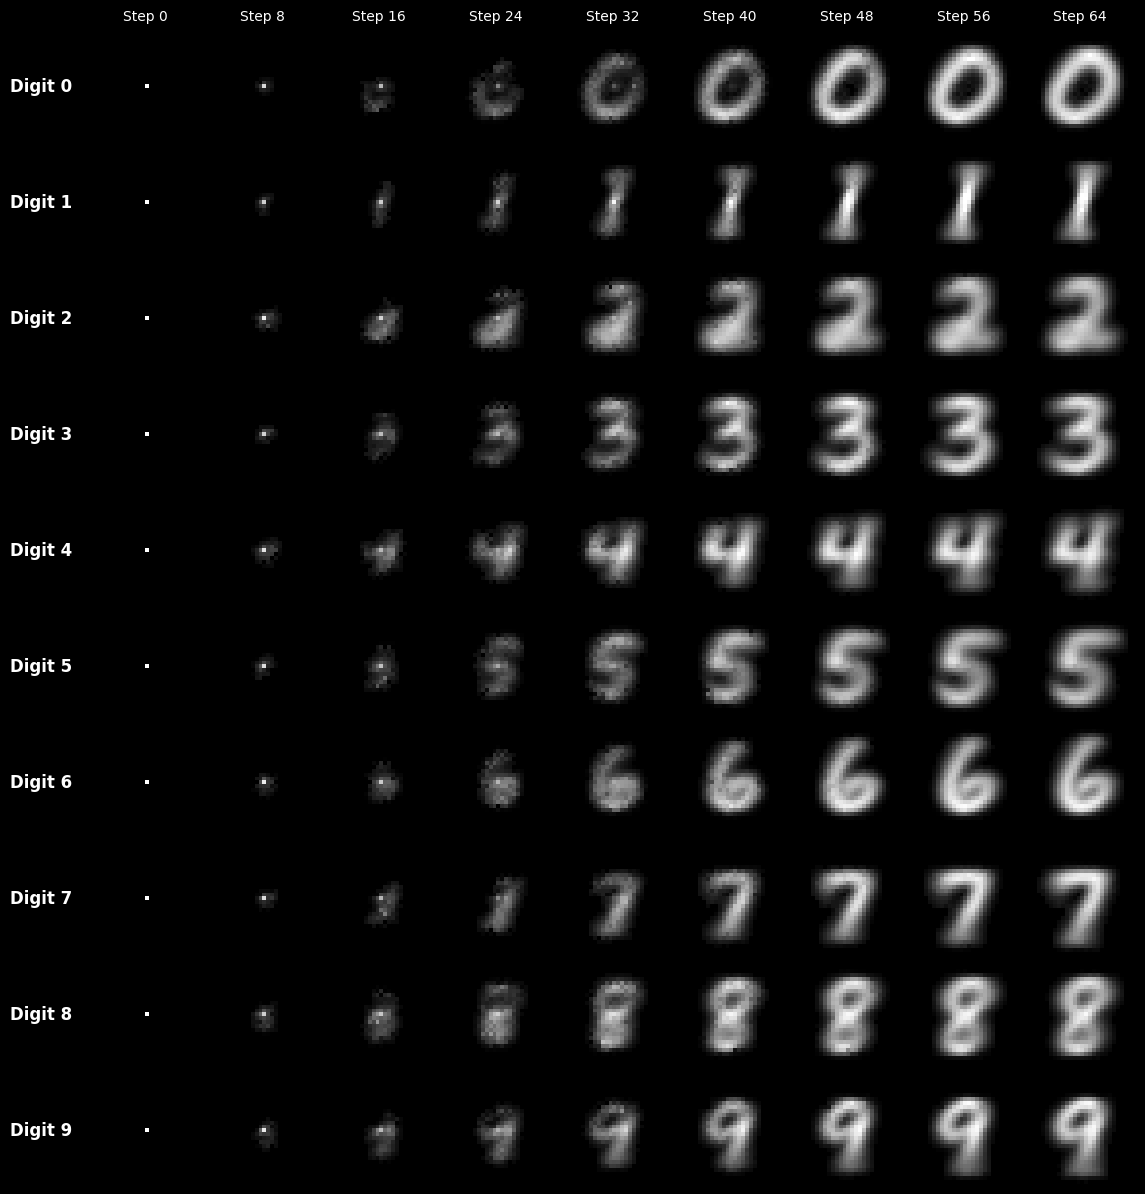

In [8]:


def show_all_digits_evolution(model, opt, max_steps=64, step_interval=8):

    model.eval()
    

    labels = torch.arange(10).to(opt.device) 
    class_vec = F.one_hot(labels, 10).float() 
    
    x = torch.zeros(10, opt.CHANNEL_N, opt.image_size, opt.image_size).to(opt.device)
    x[:, 3:, opt.image_size//2, opt.image_size//2] = 1.0 
    
    saved_snapshots = [x.clone().cpu()]
    

    
    with torch.no_grad():
        for i in range(1, max_steps + 1):
            x = model(x, class_vec, 1)
            
            if i % step_interval == 0:
                saved_snapshots.append(x.clone().cpu())
    
    num_cols = len(saved_snapshots)
    num_rows = 10                   
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 1.5, num_rows * 1.5))
    
    fig.patch.set_facecolor('black')
    
    for row in range(num_rows):     
        for col in range(num_cols): 
            ax = axes[row, col]

            img_tensor = saved_snapshots[col][row, 3].clamp(0, 1)
            
            ax.imshow(img_tensor, cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            
            if row == 0:
                ax.set_title(f"Step {col * step_interval}", color='white', fontsize=10)
            if col == 0:
                ax.text(-5, opt.image_size//2, f"Digit {row}", color='white', 
                        fontsize=12, va='center', ha='right', fontweight='bold')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

show_all_digits_evolution(model, opt, max_steps=64, step_interval=8)

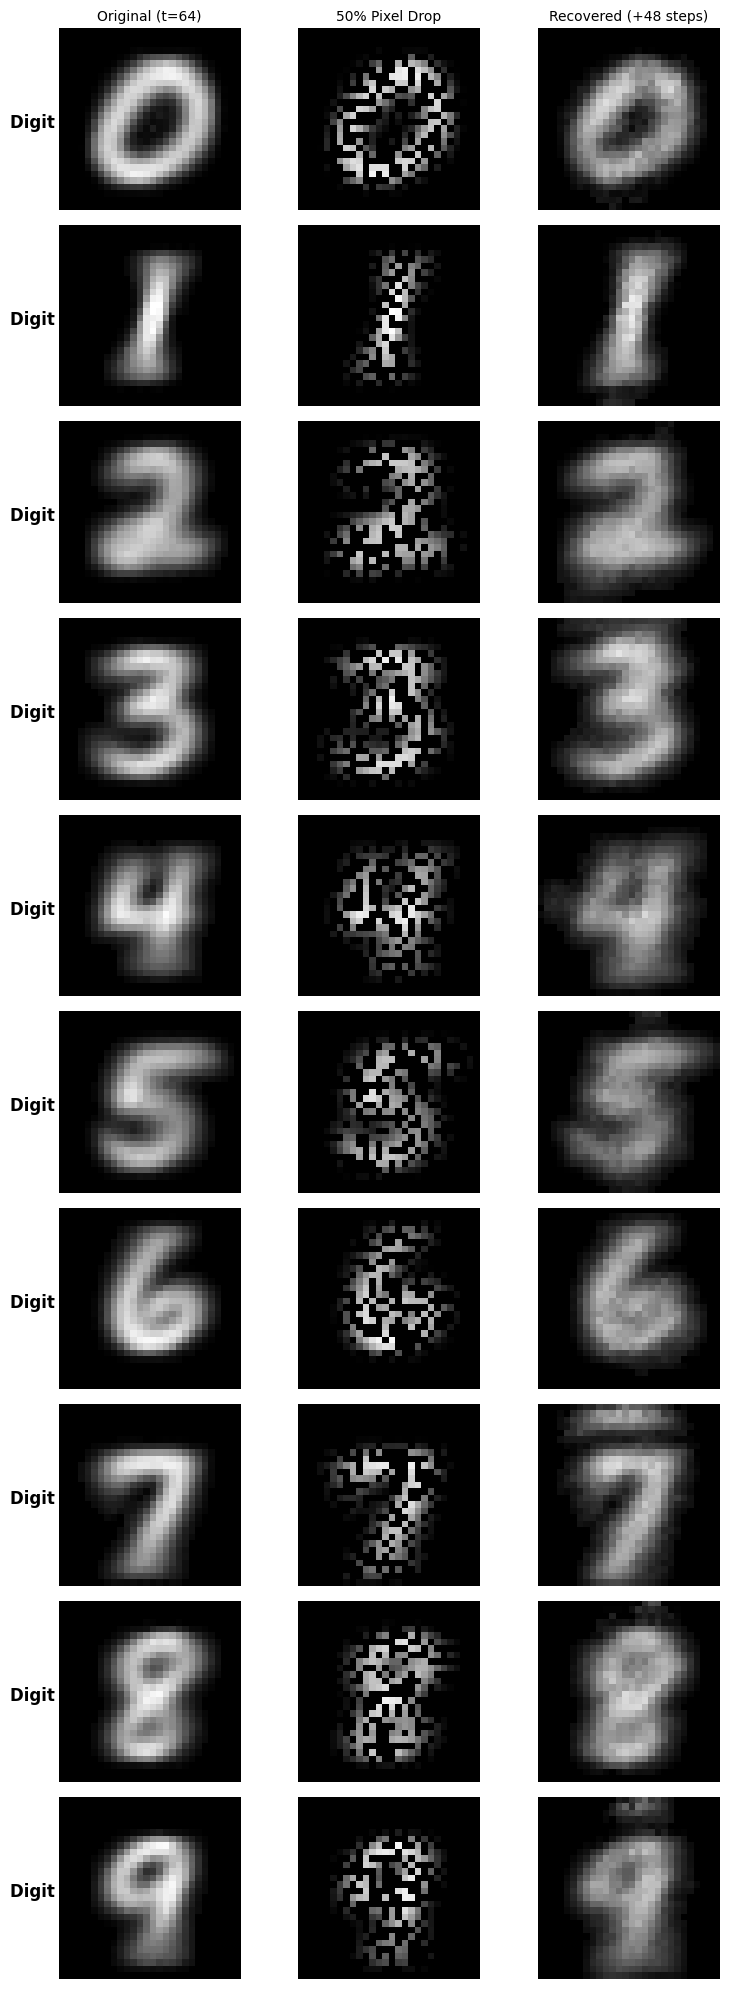

In [14]:
model.eval()

fig, axes = plt.subplots(10, 3, figsize=(8, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

with torch.no_grad():
    for digit in range(10):

        test_cls = torch.tensor([digit]).to(opt.device)
        class_vec = F.one_hot(test_cls, 10).float()
        seed = torch.zeros(1, opt.CHANNEL_N, opt.image_size, opt.image_size).to(opt.device)
        seed[:, 3:, 14, 14] = 1.0


        x_grown = model(seed, class_vec, 64)
        img_grown = x_grown[0, 3].cpu().clamp(0, 1).numpy()
        

        x_damaged = x_grown.clone()

        noise_mask = (torch.rand_like(x_damaged[:, 0:1, :, :]) > 0.5).float()
        x_damaged = x_damaged * noise_mask
        img_damaged = x_damaged[0, 3].cpu().clamp(0, 1).numpy()

  
        x_recovered = model(x_damaged, class_vec, 48)
        img_recovered = x_recovered[0, 3].cpu().clamp(0, 1).numpy()


        axes[digit, 0].imshow(img_grown, cmap='gray', vmin=0, vmax=1)
        axes[digit, 0].axis('off')
        axes[digit, 0].text(-8, 14, f"Digit {digit}", fontsize=12, fontweight='bold', va='center')
        
        axes[digit, 1].imshow(img_damaged, cmap='gray', vmin=0, vmax=1)
        axes[digit, 1].axis('off')
        
        axes[digit, 2].imshow(img_recovered, cmap='gray', vmin=0, vmax=1)
        axes[digit, 2].axis('off')

        if digit == 0:
            axes[digit, 0].set_title("Original (t=64)", fontsize=10)
            axes[digit, 1].set_title("50% Pixel Drop", fontsize=10)
            axes[digit, 2].set_title("Recovered (+48 steps)", fontsize=10)

plt.tight_layout()
plt.savefig("damage_noise_all.png", dpi=300, bbox_inches='tight')
plt.show()